<a href="https://colab.research.google.com/github/Pranjalya/sex-predator-detection/blob/master/Basic_ML_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/My\ Drive/sih_project

/content/drive/My Drive/sih_project


In [ ]:
ls

catboost_info/  data/             more_cleaned.csv  stopwords.txt
cleaned.csv     extracted_files/  pkg_data/         train_inclusive.csv


## Training and Testing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
train  = pd.read_csv('more_cleaned.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900628 entries, 0 to 900627
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   @id                    900628 non-null  object
 1   @line                  900628 non-null  int64 
 2   author                 900628 non-null  object
 3   time                   900628 non-null  object
 4   text                   774593 non-null  object
 5   sexual_predator        900628 non-null  int64 
 6   predator_conversation  900628 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 48.1+ MB


In [ ]:
train.dropna(subset = ['text'], inplace = True)
train.index = range(0, train.shape[0])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774593 entries, 0 to 774592
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   @id                    774593 non-null  object
 1   @line                  774593 non-null  int64 
 2   author                 774593 non-null  object
 3   time                   774593 non-null  object
 4   text                   774593 non-null  object
 5   sexual_predator        774593 non-null  int64 
 6   predator_conversation  774593 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 41.4+ MB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(train['text'].apply(lambda x: np.str_(x))), 
                                                    np.array(train['sexual_predator']), stratify = np.array(train['sexual_predator']),
                                                    test_size=0.20, random_state=62)

In [ ]:
freq, freq2 = np.unique(y_train, return_counts = True)[1]
freq3, freq4 = np.unique(y_test, return_counts = True)[1]
print(f'Frequency in Training set :- Normal users : {((freq/(freq+freq2))*100):.2f}% ; Sexual predators : {((freq2/(freq+freq2))*100):.2f}%')
print(f'Frequency in Testing set :- Normal users : {((freq3/(freq3+freq4))*100):.2f}% ; Sexual predators : {((freq4/(freq3+freq4))*100):.2f}%')

Frequency in Training set :- Normal users : 95.61% ; Sexual predators : 4.39%
Frequency in Testing set :- Normal users : 95.61% ; Sexual predators : 4.39%


In [ ]:
tfidf = TfidfVectorizer(min_df = 0., max_df = 1., norm = 'l2', use_idf = True, smooth_idf = True)

train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)

print(train_tfidf.shape)
print(test_tfidf.shape)

(619674, 114159)
(154919, 114159)


## Models

In [ ]:
!pip -q install catboost

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
classifiers = [
    CatBoostClassifier(iterations=50, random_seed=42, learning_rate=0.5, custom_loss=['AUC', 'Accuracy']),
    DecisionTreeClassifier(),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    KNeighborsClassifier(4, n_jobs=-1)]

In [ ]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(train_tfidf, y_train)
    name = clf.__class__.__name__
    
    print("="*33)
    print(name)
    
    print('*****Results*****')
    train_predictions = clf.predict(test_tfidf)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    predictions = clf.predict_proba(test_tfidf)
    ll = log_loss(y_test, predictions)
    print("Log Loss: {}".format(ll))

    print(classification_report(y_test, train_predictions))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    print("-"*33)
    
print("="*33)
log.to_csv('initial_res.csv')

0:	learn: 0.2615088	total: 1.25s	remaining: 1m 19s
1:	learn: 0.1934336	total: 2.48s	remaining: 1m 18s
2:	learn: 0.1785445	total: 3.73s	remaining: 1m 17s
3:	learn: 0.1744049	total: 5.01s	remaining: 1m 16s
4:	learn: 0.1726090	total: 6.27s	remaining: 1m 15s
5:	learn: 0.1704807	total: 7.55s	remaining: 1m 14s
6:	learn: 0.1694868	total: 8.83s	remaining: 1m 13s
7:	learn: 0.1681487	total: 10.1s	remaining: 1m 12s
8:	learn: 0.1673608	total: 11.4s	remaining: 1m 10s
9:	learn: 0.1664987	total: 12.6s	remaining: 1m 9s
10:	learn: 0.1657876	total: 13.9s	remaining: 1m 8s
11:	learn: 0.1654013	total: 15.2s	remaining: 1m 7s
12:	learn: 0.1649816	total: 16.5s	remaining: 1m 5s
13:	learn: 0.1645100	total: 17.7s	remaining: 1m 4s
14:	learn: 0.1640786	total: 18.9s	remaining: 1m 3s
15:	learn: 0.1637435	total: 20.2s	remaining: 1m 1s
16:	learn: 0.1632786	total: 21.5s	remaining: 1m
17:	learn: 0.1629127	total: 22.7s	remaining: 59.3s
18:	learn: 0.1625037	total: 24s	remaining: 58s
19:	learn: 0.1621391	total: 25.2s	remai

KeyboardInterrupt: ignored

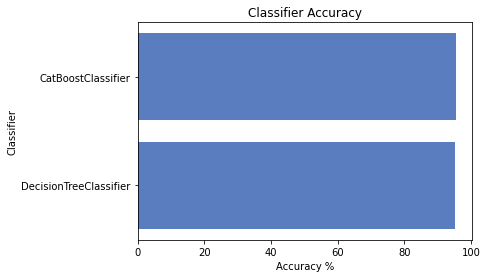

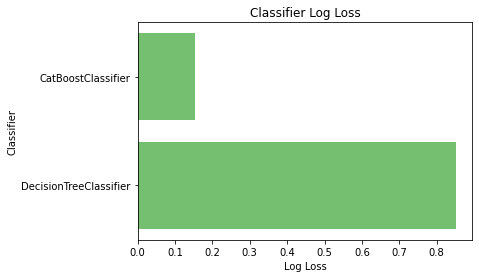

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

## Oversampling to reduce comparative difference

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_sm, y_sm = sm.fit_sample(train_tfidf, y_train)

In [ ]:
freq, freq2 = np.unique(y_sm, return_counts = True)[1]
print(f'Frequency of Normal users : {((freq/(freq+ freq2))*100):.2f}% ; Sexual predators : {((freq2/(freq+ freq2))*100):.2f}%')

Frequency of Normal users : 50.00% ; Sexual predators : 50.00%


In [ ]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_sm, y_sm)
    name = clf.__class__.__name__
    
    print("="*33)
    print(name)
    
    print('*****Results*****')
    train_predictions = clf.predict(test_tfidf)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    predictions = clf.predict_proba(test_tfidf)
    ll = log_loss(y_test, predictions)
    print("Log Loss: {}".format(ll))

    print(classification_report(y_test, train_predictions))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*33)
log.to_csv('oversampling_res.csv')

0:	learn: 0.6560184	total: 2.03s	remaining: 1m 39s
1:	learn: 0.6415688	total: 3.98s	remaining: 1m 35s
2:	learn: 0.6330475	total: 5.87s	remaining: 1m 32s
3:	learn: 0.6250842	total: 7.73s	remaining: 1m 28s
4:	learn: 0.6170303	total: 9.61s	remaining: 1m 26s
5:	learn: 0.6108605	total: 11.4s	remaining: 1m 23s
6:	learn: 0.6056406	total: 13.2s	remaining: 1m 21s
7:	learn: 0.5999094	total: 15s	remaining: 1m 18s
8:	learn: 0.5945690	total: 16.8s	remaining: 1m 16s
9:	learn: 0.5906476	total: 18.6s	remaining: 1m 14s
10:	learn: 0.5862008	total: 20.5s	remaining: 1m 12s
11:	learn: 0.5824997	total: 22.3s	remaining: 1m 10s
12:	learn: 0.5794471	total: 24.1s	remaining: 1m 8s
13:	learn: 0.5760131	total: 25.9s	remaining: 1m 6s
14:	learn: 0.5721459	total: 27.7s	remaining: 1m 4s
15:	learn: 0.5694452	total: 29.5s	remaining: 1m 2s
16:	learn: 0.5664161	total: 32.5s	remaining: 1m 3s
17:	learn: 0.5635437	total: 34.8s	remaining: 1m 1s
18:	learn: 0.5610020	total: 36.5s	remaining: 59.6s
19:	learn: 0.5586687	total: 38.

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

The list of models were taking too long to execute, due to large set of features. Would be dividing the task.